# DynamicDPI
Message-passing with Deep Probabilistic Imaging (DPI) to reconstruct video of quickly-evolving sources. The goal is to capture the appearance and dyanmics, while quantifying uncertainty, by learning the posterior distributions rather than just point estimates. We compute forwared and backward messages for the sum-product algorithm in order to calculate the marginal distributions, to perform inference on a graphical model of the hidden images.

## Overview of DPI
DPI parameterizes the latent image distribution using a flow-based generative model $G_{\theta}$ to learn an approximate distribution $q_{\theta}$. The weights $\theta$ are learned by minimizing the Kullback-Leibler (KL) divergence between $q_{\theta}$ and the image posterior $p(x|y)$

Succinctly, $x \sim q_{\theta} (x) \Leftrightarrow x = G_{\theta}, z \sim \mathcal{N}(0,1)$. 

\begin{equation}
    \theta^{*} = \text{argmin}_{\theta} D_{KL} (q_{\theta} (x) || p(x | y)) = \text{argmin}_{\theta} \mathbb{E}_{x \sim q_{\theta} (x)} [- \log p(y|x) - \log p(x) + \log q_{\theta} (x)]
\end{equation}

Note that Normalizing Flows provide exact log-likelihood calculation through the change of variables theorem, and thus $\log q_{\theta} (x) = \log \pi (z) - \log \left| \text{det} \frac{dG_{\theta} (z)}{dz} \right|$. Thus, the stochastic optimization problem becomes

\begin{equation}
    \theta^{*} = \text{argmin}_{\theta} \mathbb{E}_{z \sim \mathcal{N}(0,1)} \left[ -\log p(y | G_{\theta} (z)) - \log p(G_{\theta} (z)) + \log \pi(x) - \log \left| \text{det} \frac{dG_{\theta} (z)}{dz} \right| \right]
\end{equation}

By using a Monte Carlo method to approximate the expectation over the standard normal distribution and by replacing the data likelihood and prior terms with the data fitting loss and regularization functions, we get:

\begin{equation}
    \theta^{*} = \text{argmin}_{\theta} \sum_{k=1}^{N} \left[ \mathcal{L} (y, f(G_{\theta} (z_{k}))) + \lambda \mathcal{R} (G_{\theta} (z_{k})) - \beta \log \left| \text{det} \frac{dG_{\theta} (z_{k})}{dz_{k}} \right| \right]
\end{equation}

Where the $\beta$ parameter allows us to tune the diversity of the reconstructions via adjustment of the generative distribution's entropy. Intuitively, $\beta$ encourages more exploration during training.

In [4]:
!ls ../DPItorch

checkpoint	       generative_model		  train_dpi_interferometry.sh
DPI_2Dtoydist.py       interferometry_helpers.py  train_dpi_mri.sh
DPI_interferometry.py  MRI_helpers.py
DPI_MRI.py	       notebooks


In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as functional

torch.set_default_dtype(torch.float32)
import torch.optim as optim
import pickle
import math
# from sys import exit
import matplotlib.pyplot as plt
from sklearn import datasets

import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

from DPItorch.generative_model import realnvpfc_model

Set up toy example: Gaussian mixture (four bivariate Gaussians)

In [4]:
# Example 1 - Gaussian mixture
x1, y1, a1, sigma1 = -0.5, -0.5, 1, 0.4
x2, y2, a2, sigma2 = -0.5, 0.5, 1, 0.4
x3, y3, a3, sigma3 = 0.5, -0.5, 1, 0.4
x4, y4, a4, sigma4 = 0.5, 0.5, 1, 0.4
log_prob1 = lambda x, y: torch.log(a1 * torch.exp(-1/sigma1**2*((x-x1)**2+(y-y1)**2)) + \
                        a2 * torch.exp(-1/sigma2**2*((x-x2)**2+(y-y2)**2)) + \
                        a3 * torch.exp(-1/sigma3**2*((x-x3)**2+(y-y3)**2)) + \
                        a4 * torch.exp(-1/sigma4**2*((x-x4)**2+(y-y4)**2)))

Train DPI: train the normalizing flow to approximate the probability distribution defined earlier

epoch: 299, loss: 3.74737
epoch: 599, loss: 3.68359
epoch: 899, loss: 3.66782
epoch: 1199, loss: 3.65578
epoch: 1499, loss: 3.59218
epoch: 1799, loss: 3.54653
epoch: 2099, loss: 3.71498
epoch: 2399, loss: 3.54488
epoch: 2699, loss: 3.59891
epoch: 2999, loss: 3.59231


(<Figure size 432x288 with 1 Axes>,
 Text(0.5, 0, 'epochs'),
 Text(0, 0.5, 'loss'))

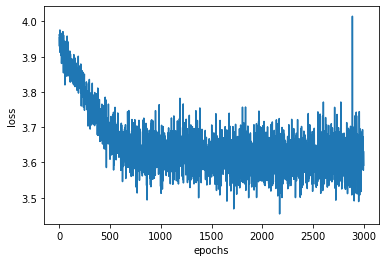

In [5]:
loss_func = lambda x, y: -log_prob1(x, y) # select the likelihood function to estimate

# Define the architecture of normalizing flow
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")#torch.device("cpu")#

affine = True
n_flow = 16#8#32
generator = realnvpfc_model.RealNVP(2, n_flow, affine=affine, seqfrac=1/128).to(device)

# define the optimizer
optimizer = optim.Adam(generator.parameters(), lr = 1e-5)

n_epoch = 3000 # number of optimization steps
diversity = 1 # weight of the diversity loss
n_samples = 512 # number of samples in each optimization step

# start optimization
loss_list = []
sample_list = []
for k in range(n_epoch):
    x_samples_transformed, logdet = generator.reverse(torch.randn((n_samples, 2)).to(device))
    x_samples = 2 * torch.sigmoid(x_samples_transformed) - 1
    det_sigmoid = torch.sum(-x_samples_transformed - 2 * torch.nn.Softplus()(-x_samples_transformed), -1)
    logdet = logdet + det_sigmoid

    loss = torch.mean(loss_func(x_samples[:, 0], x_samples[:, 1]) - diversity * logdet)
    loss_list.append(loss.detach().cpu().numpy())

    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(generator.parameters(), 1e-5)
    optimizer.step()

    if (k + 1) % 300 == 0:
        print(f"epoch: {k:}, loss: {loss.item():.5f}")
        sample_list.append(x_samples.detach().cpu().numpy())

plt.figure(), plt.plot(loss_list), plt.xlabel('epochs'), plt.ylabel('loss')

[Text(0.5, 0, 'Learned distribution')]

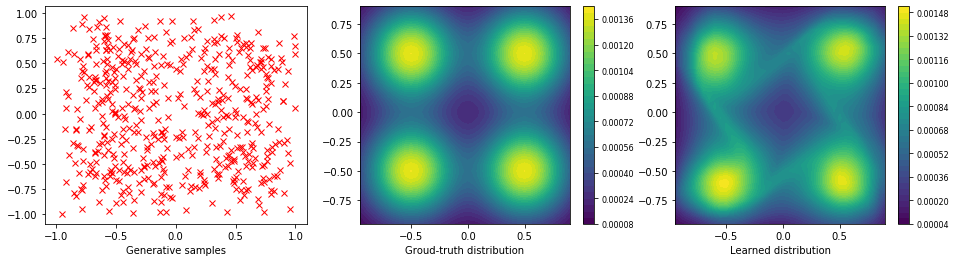

In [13]:
generator.training = False
fig, axs = plt.subplots(1, 3, figsize=(16, 4))

# plot generative samples
x_samples_transformed, logdet = generator.reverse(torch.randn((n_samples, 2)).to(device))
x_samples = 2 * torch.sigmoid(x_samples_transformed) - 1
x_generated = x_samples.detach().cpu().numpy()
# plt.figure(), plt.plot(x_generated[:, 0], x_generated[:, 1], 'rx')
# plt.title('Generative samples')
axs[0].plot(x_generated[:, 0], x_generated[:, 1], 'rx')
axs[0].set(xlabel='Generative samples')

# plot the ground-truth distribution
x_range = np.arange(-0.95, 0.95, 0.05)
y_range = np.arange(-0.95, 0.95, 0.05)

X, Y = np.meshgrid(x_range, y_range)
value = loss_func(torch.tensor(X), torch.tensor(Y)).numpy()
Z = np.array(value)
prob_true = np.exp(-Z) / np.sum(np.exp(-Z))

im = axs[1].contourf(X, Y, prob_true, 40)
cbar = fig.colorbar(im, ax=axs[1])
cbar.ax.tick_params(labelsize=8)
axs[1].set(xlabel='Groud-truth distribution')

# plot the learned distribution
X_reshape = X.reshape((-1, 1))
Y_reshape = Y.reshape((-1, 1))
XY_reshape = np.concatenate([X_reshape, Y_reshape], -1).astype(np.float32)
XY_reshape_torch = torch.tensor(XY_reshape).to(device)
XY_reshape_transoformed = torch.log(1+XY_reshape_torch+1e-8) - torch.log(1-XY_reshape_torch+1e-8)
random_samples, logdet = generator.forward(XY_reshape_transoformed)
det_sigmoid = torch.sum(XY_reshape_transoformed + 2 * torch.nn.Softplus()(-XY_reshape_transoformed), -1)
logdet = logdet + det_sigmoid

logprob = logdet.cpu().detach().numpy() - 0.5 * np.sum((random_samples.cpu().detach().numpy())**2+np.log(2*np.pi), -1)
logprob = logprob.reshape(X.shape)
prob = np.exp(logprob) / np.sum(np.exp(logprob))

im = axs[2].contourf(X_reshape.reshape((len(x_range), len(y_range))), Y_reshape.reshape((len(x_range), len(y_range))), prob, 40)
cbar = fig.colorbar(im, ax=axs[2])
cbar.ax.tick_params(labelsize=8)
axs[2].set(xlabel='Learned distribution')

## Probabilistic Graphical Model
We use a probabilistic graphical model to represent the hidden images of the dynamically-evolving source. Specifically, we start with an undirected tree graph without loops, and at each time step, we make use of three potential functions: 

\begin{equation}
    \begin{aligned}
    \phi_{y_{t} | x_{t}} &= \mathcal{N}_{y_{t}} ( f_{t} (x_{t}), R_{t}) \\
    \phi_{x_{t}} &= \mathcal{N}_{x_{1}} (\mu_{t}, \Lambda_{t}), \\ 
    \phi_{x_{t} | x_{t-1}} &= \mathcal{N}_{x_{t}} (A x_{t-1}, Q),
    \\
    \end{aligned}
\end{equation}

Where $x_{t}$ is an instantaneous hidden image reconstructed from a sparse set of frequency measurements $y_{t}$. The measurement function $f(x)$ can be a linear (just the complex visibilities) or non-linear (bispectrum and closure phases, invariant to atmospheric inhomogeneity) function of $x$ depending on which data products are being measured. And $R$ is the corresponding noise associated with the measurements $y$. And each instantaneous image is encouraged to be a sample from a multivariate Gaussian distribution (our prior) with time-independent covariance matrix $\Lambda$. And finally, the joint potential encodes our knowledge of the dynamic evolution model $A$, with covariance matrix $Q$ constraining additional intensity perturbations. For now, we assume the evolution model $A$ is known.

### Inference
We need to compute the marginal distributions for each instantaneous image $x_{t}$ conditioned on all the sparse observations $y_{1} \ldots y_{N}$. We can carry out this marginalization using the Elimination Algorithm: $p(x_{t} | y_{1:N}) \propto p(x_{t}, y_{1:N}) \propto \phi_{t} (x_{t}) m_{t-1 \rightarrow t} (x_{t}) m_{t+1 \rightarrow t} (x_{t})$. 

Specifically, we use the sum-product algorithm, which is more efficient than the vanilla Elimination Algorithm, to retrieve marginals for multiple different variables. Define the unary potential functions as $\phi_{t} (x_{t}) = p(y_{t} | x_{t}) p(x_{t})$. Note that in the Gaussian case of convex imaging with the linear non-closure quantities, we express this unary potential exactly as $\phi_{t} (x_{t}) = \mathcal{N}_{y_{t}} (F_{t} x_{t}, R_{t}) \mathcal{N}_{x_{t}} (\mu, \Lambda)$. Define the joint potential functions as $\psi_{t-1, t} (x_{t-1}, x_{t}) = p(x_{t} | x_{t-1}) = \mathcal{N}_{x_{t}} (A x_{t-1}, Q)$.

The resulting sum-product messages are:

\begin{equation}
    \begin{aligned}
        m_{1 \rightarrow 2} (x_{2}) &= \int_{x_{1}} \phi_{1} (x_{1}) \psi_{1,2} (x_{1}, x_{2}) dx_{1},
        \\
        m_{t \rightarrow t+1} (x_{t+1}) &= \int_{x_{t}} \phi_{t} (x_{t}) \psi_{t,t+1} (x_{t}, x_{t+1}) m_{t-1 \rightarrow t} (x_{t}) dx_{t},
        \\
        m_{N \rightarrow N-1} (x_{N-1}) &= \int_{x_{N}} \phi_{N} (x_{N}) \psi_{N-1,N} (x_{N-1}, x_{N}) dx_{N},
        \\
        m_{t \rightarrow t-1} (x_{t-1}) &= \int_{x_{t}} \phi_{t} (x_{t}) \psi_{t-1,t} (x_{t-1}, x_{t}) m_{t+1 \rightarrow t} (x_{t}) dx_{t},
        \\
    \end{aligned}
\end{equation}

### Implementation: Sum-Product Algorithm
Also known as Belief Propagation

In [3]:
import numpy as np
from collections import namedtuple

In [4]:
LabeledArray = namedtuple('LabeledArray', [
    'array',
    'axes_labels',
])

def name_to_axis_mapping(labeled_array):
    return {
        name: axis
        for axis, name in enumerate(labeled_array.axes_labels)
    }

def other_axes_from_labeled_axes(labeled_array, axis_label):
    # returns the indexes of the axes that are not axis label
    return tuple(
        axis
        for axis, name in enumerate(labeled_array.axes_labels)
        if name != axis_label
    )

In [5]:
def is_conditional_prob(labeled_array, var_name):
    '''
    labeled_array (LabeledArray)
    variable (str): name of variable, i.e. 'a' in p(a|b)
    '''
    return np.all(np.isclose(np.sum(
        labeled_array.array,
        axis=name_to_axis_mapping(labeled_array)[var_name]
    ), 1.0))
    
def is_joint_prob(labeled_array):
    return np.all(np.isclose(np.sum(labeled_array.array), 1.0))

In [6]:
p_v1_given_h1 = LabeledArray(np.array([[0.4, 0.8, 0.9], [0.6, 0.2, 0.1]]), ['v1', 'h1'])

p_h1 = LabeledArray(np.array([0.6, 0.3, 0.1]), ['h1'])

p_v1_given_many = LabeledArray(np.array(
    [[[0.9, 0.2], [0.3, 0.2]],
     [[0.1, 0.8], [0.7, 0.8]]]
), ['v1', 'h1', 'h2'])

assert is_conditional_prob(p_v1_given_h1, 'v1')
assert not is_joint_prob(p_v1_given_h1)

assert is_conditional_prob(p_h1, 'h1')
assert is_joint_prob(p_h1)

assert is_conditional_prob(p_v1_given_many, 'v1')
assert not is_joint_prob(p_v1_given_many)

In [7]:
def tile_to_shape_along_axis(arr, target_shape, target_axis):
    # get a list of all axes
    raw_axes = list(range(len(target_shape)))
    tile_dimensions = [target_shape[a] for a in raw_axes if a != target_axis]
    if len(arr.shape) == 0:
        # If given a scalar, also tile it in the target dimension (so it's a bunch of 1s)
        tile_dimensions += [target_shape[target_axis]]
    elif len(arr.shape) == 1:
        # If given an array, it should be the same shape as the target axis
        assert arr.shape[0] == target_shape[target_axis]
        tile_dimensions += [1]
    else:
        raise NotImplementedError()
    tiled = np.tile(arr, tile_dimensions)

    # Tiling only adds prefix axes, so rotate this one back into place
    shifted_axes = raw_axes[:target_axis] + [raw_axes[-1]] + raw_axes[target_axis:-1]
    transposed = np.transpose(tiled, shifted_axes)

    # Double-check this code tiled it to the correct shape
    assert transposed.shape == target_shape
    return transposed

def tile_to_other_dist_along_axis_name(tiling_labeled_array, target_array):
    assert len(tiling_labeled_array.axes_labels) == 1
    target_axis_label = tiling_labeled_array.axes_labels[0]
    
    return LabeledArray(
        tile_to_shape_along_axis(
            tiling_labeled_array.array,
            target_array.array.shape,
            name_to_axis_mapping(target_array)[target_axis_label]
        ),
        axes_labels=target_array.axes_labels
    )

In [8]:
tiled_p_h1 = tile_to_other_dist_along_axis_name(p_h1, p_v1_given_h1)

# Check that the product is a joint distribution (p(v1, h1))
assert np.isclose(np.sum(p_v1_given_h1.array * tiled_p_h1.array), 1.0)

#### Factor Graphs

In [11]:
class Node(object):
    def __init__(self, name):
        self.name = name
        self.neighbors = []

    def __repr__(self):
        return "{classname}({name}, [{neighbors}])".format(
            classname=type(self).__name__,
            name=self.name,
            neighbors=', '.join([n.name for n in self.neighbors])
        )

    def is_valid_neighbor(self, neighbor):
        raise NotImplemented()

    def add_neighbor(self, neighbor):
        assert self.is_valid_neighbor(neighbor)
        self.neighbors.append(neighbor)


class Variable(Node):
    def is_valid_neighbor(self, factor):
        return isinstance(factor, Factor)  # Variables can only neighbor Factors


class Factor(Node):
    def is_valid_neighbor(self, variable):
        return isinstance(variable, Variable)  # Factors can only neighbor Variables

    def __init__(self, name):
        super(Factor, self).__init__(name)
        self.data = None

#### Parse distributions into graphs

In [12]:
ParsedTerm = namedtuple('ParsedTerm', [
    'term',
    'var_name',
    'given',
])


def _parse_term(term):
    # Given a term like (a|b,c), returns a list of variables
    # and conditioned-on variables
    assert term[0] == '(' and term[-1] == ')'
    term_variables = term[1:-1]

    # Handle conditionals
    if '|' in term_variables:
        var, given = term_variables.split('|')
        given = given.split(',')
    else:
        var = term_variables
        given = []

    return var, given


def _parse_model_string_into_terms(model_string):
    return [
        ParsedTerm('p' + term, *_parse_term(term))
        for term in model_string.split('p')
        if term
    ]

def parse_model_into_variables_and_factors(model_string):
    # Takes in a model_string such as p(h1)p(h2∣h1)p(v1∣h1)p(v2∣h2) and returns a
    # dictionary of variable names to variables and a list of factors.
    
    # Split model_string into ParsedTerms
    parsed_terms = _parse_model_string_into_terms(model_string)
    
    # First, extract all of the variables from the model_string (h1, h2, v1, v2). 
    # These each will be a new Variable that are referenced from Factors below.
    variables = {}
    for parsed_term in parsed_terms:
        # if the variable name wasn't seen yet, add it to the variables dict
        if parsed_term.var_name not in variables:
            variables[parsed_term.var_name] = Variable(parsed_term.var_name)

    # Now extract factors from the model. Each term (e.g. "p(v1|h1)") corresponds to 
    # a factor. 
    # Then find all variables in this term ("v1", "h1") and add the corresponding Variables
    # as neighbors to the new Factor, and this Factor to the Variables' neighbors.
    factors = []
    for parsed_term in parsed_terms:
        # This factor will be neighbors with all "variables" (left-hand side variables) and given variables
        new_factor = Factor(parsed_term.term)
        all_var_names = [parsed_term.var_name] + parsed_term.given
        for var_name in all_var_names:
            new_factor.add_neighbor(variables[var_name])
            variables[var_name].add_neighbor(new_factor)
        factors.append(new_factor)

    return factors, variables

In [13]:
parse_model_into_variables_and_factors("p(h1)p(h2|h1)p(v1|h1)p(v2|h2)")

([Factor(p(h1), [h1]),
  Factor(p(h2|h1), [h2, h1]),
  Factor(p(v1|h1), [v1, h1]),
  Factor(p(v2|h2), [v2, h2])],
 {'h1': Variable(h1, [p(h1), p(h2|h1), p(v1|h1)]),
  'h2': Variable(h2, [p(h2|h1), p(v2|h2)]),
  'v1': Variable(v1, [p(v1|h1)]),
  'v2': Variable(v2, [p(v2|h2)])})

#### Adding distributions to graph

In [14]:
class PGM(object):
    def __init__(self, factors, variables):
        self._factors = factors
        self._variables = variables

    @classmethod
    def from_string(cls, model_string):
        factors, variables = parse_model_into_variables_and_factors(model_string)
        return PGM(factors, variables)

    def set_data(self, data):
        # Keep track of variable dimensions to check for shape mistakes
        var_dims = {}
        for factor in self._factors:
            factor_data = data[factor.name]

            if set(factor_data.axes_labels) != set(v.name for v in factor.neighbors):
                missing_axes = set(v.name for v in factor.neighbors) - set(data[factor.name].axes_labels)
                raise ValueError("data[{}] is missing axes: {}".format(factor.name, missing_axes))
                
            for var_name, dim in zip(factor_data.axes_labels, factor_data.array.shape):
                if var_name not in var_dims:
                    var_dims[var_name] = dim
    
                if var_dims[var_name] != dim:
                    raise ValueError("data[{}] axes is wrong size, {}. Expected {}".format(factor.name, dim, var_dims[var_name]))            
                    
            factor.data = data[factor.name]
            
    def variable_from_name(self, var_name):
        return self._variables[var_name]

In [15]:
p_h1 = LabeledArray(np.array([[0.2], [0.8]]), ['h1'])
p_h2_given_h1 = LabeledArray(np.array([[0.5, 0.2], [0.5, 0.8]]), ['h2', 'h1'])
p_v1_given_h1 = LabeledArray(np.array([[0.6, 0.1], [0.4, 0.9]]), ['v1', 'h1'])
p_v2_given_h2 = LabeledArray(p_v1_given_h1.array, ['v2', 'h2'])

assert is_joint_prob(p_h1)
assert is_conditional_prob(p_h2_given_h1, 'h2')
assert is_conditional_prob(p_v1_given_h1, 'v1')
assert is_conditional_prob(p_v2_given_h2, 'v2')

In [16]:
pgm = PGM.from_string("p(h1)p(h2|h1)p(v1|h1)p(v2|h2)")

pgm.set_data({
    "p(h1)": p_h1,
    "p(h2|h1)": p_h2_given_h1,
    "p(v1|h1)": p_v1_given_h1,
    "p(v2|h2)": p_v2_given_h2,
})

#### Belief Propagation

In [17]:
def _variable_to_factor_messages(variable, factor):
    # Take the product over all incoming factors into this variable except the variable
    incoming_messages = [
        _factor_to_variable_message(neighbor_factor, variable)
        for neighbor_factor in variable.neighbors
        if neighbor_factor.name != factor.name
    ]

    # If there are no incoming messages, this is 1
    return np.prod(incoming_messages, axis=0)

In [18]:
def _factor_to_variable_messages(factor, variable):
    # Compute the product
    factor_dist = np.copy(factor.data.array)
    for neighbor_variable in factor.neighbors:
        if neighbor_variable.name == variable.name:
            continue
        incoming_message = variable_to_factor_messages(neighbor_variable, factor)
        factor_dist *= tile_to_other_dist_along_axis_name(
            LabeledArray(incoming_message, [neighbor_variable.name]),
            factor.data
        ).array
    # Sum over the axes that aren't `variable`
    other_axes = other_axes_from_labeled_axes(factor.data, variable.name)
    return np.squeeze(np.sum(factor_dist, axis=other_axes))

In [19]:
def marginal(variable):
    # p(variable) is proportional to the product of incoming messages to variable.
    unnorm_p = np.prod([
        self.factor_to_variable_message(neighbor_factor, variable)
        for neighbor_factor in variable.neighbors
    ], axis=0)

    # At this point, we can normalize this distribution
    return unnorm_p/np.sum(unnorm_p)

In [20]:
class Messages(object):
    def __init__(self):
        self.messages = {}
        
    def _variable_to_factor_messages(self, variable, factor):
        # Take the product over all incoming factors into this variable except the variable
        incoming_messages = [
            self.factor_to_variable_message(neighbor_factor, variable)
            for neighbor_factor in variable.neighbors
            if neighbor_factor.name != factor.name
        ]

        # If there are no incoming messages, this is 1
        return np.prod(incoming_messages, axis=0)
    
    def _factor_to_variable_messages(self, factor, variable):
        # Compute the product
        factor_dist = np.copy(factor.data.array)
        for neighbor_variable in factor.neighbors:
            if neighbor_variable.name == variable.name:
                continue
            incoming_message = self.variable_to_factor_messages(neighbor_variable, factor)
            factor_dist *= tile_to_other_dist_along_axis_name(
                LabeledArray(incoming_message, [neighbor_variable.name]),
                factor.data
            ).array
        # Sum over the axes that aren't `variable`
        other_axes = other_axes_from_labeled_axes(factor.data, variable.name)
        return np.squeeze(np.sum(factor_dist, axis=other_axes))
    
    def marginal(self, variable):
        # p(variable) is proportional to the product of incoming messages to variable.
        unnorm_p = np.prod([
            self.factor_to_variable_message(neighbor_factor, variable)
            for neighbor_factor in variable.neighbors
        ], axis=0)

        # At this point, we can normalize this distribution
        return unnorm_p/np.sum(unnorm_p)
    
    def variable_to_factor_messages(self, variable, factor):
        message_name = (variable.name, factor.name)
        if message_name not in self.messages:
            self.messages[message_name] = self._variable_to_factor_messages(variable, factor)
        return self.messages[message_name]
        
    def factor_to_variable_message(self, factor, variable):
        message_name = (factor.name, variable.name)
        if message_name not in self.messages:
            self.messages[message_name] = self._factor_to_variable_messages(factor, variable)
        return self.messages[message_name]       

In [21]:
pgm = PGM.from_string("p(h1)p(h2|h1)p(v1|h1)p(v2|h2)")

pgm.set_data({
    "p(h1)": p_h1,
    "p(h2|h1)": p_h2_given_h1,
    "p(v1|h1)": p_v1_given_h1,
    "p(v2|h2)": p_v2_given_h2,
})

m = Messages()
m.marginal(pgm.variable_from_name('v2'))

array([0.23, 0.77])

In [22]:
m.messages

{('p(h1)', 'h1'): array([0.2, 0.8]),
 ('v1', 'p(v1|h1)'): 1.0,
 ('p(v1|h1)', 'h1'): array([1., 1.]),
 ('h1', 'p(h2|h1)'): array([0.2, 0.8]),
 ('p(h2|h1)', 'h2'): array([0.26, 0.74]),
 ('h2', 'p(v2|h2)'): array([0.26, 0.74]),
 ('p(v2|h2)', 'v2'): array([0.23, 0.77])}

In [23]:
m.marginal(pgm.variable_from_name('v1'))

array([0.2, 0.8])

In [24]:
pgm = PGM.from_string("p(x5|x4)p(x4|x3)p(x3|x2)p(x2|x1)p(x1)")

p_x5_given_x4 = LabeledArray(np.array([[0.7, 0.5, 0], [0.3, 0.3, 0.5], [0, 0.2, 0.5]]), ['x5', 'x4'])
assert is_conditional_prob(p_x5_given_x4, 'x5')
p_x4_given_x3 = LabeledArray(p_x5_given_x4.array, ['x4', 'x3'])
p_x3_given_x2 = LabeledArray(p_x5_given_x4.array, ['x3', 'x2'])
p_x2_given_x1 = LabeledArray(p_x5_given_x4.array, ['x2', 'x1'])
p_x1 = LabeledArray(np.array([1, 0, 0]), ['x1'])

pgm.set_data({
    "p(x5|x4)": p_x5_given_x4,
    "p(x4|x3)": p_x4_given_x3,
    "p(x3|x2)": p_x3_given_x2,
    "p(x2|x1)": p_x2_given_x1,
    "p(x1)": p_x1,
})

Messages().marginal(pgm.variable_from_name('x5'))

array([0.5746, 0.318 , 0.1074])

### Message Passing with DPI

First, we learn the instantaneous posterior distribution of the first image, $p(x_{1} | y_{1})$, which corresponds to the first unary potential $\phi_{1} = p(y_{1} | x_{1}) p(x_{1})$. We do this by training the DPI procedure using the first set of sparse observations $y_{1}$, resulting in a flow-based generative model from which we sample $x_{1}$

$x_{1} \sim q_{\theta_{1}} (x_{1}) \Leftrightarrow x_{1} = G_{\theta_{1}} (z), z \sim \mathcal{N} (0,1)$

Where, as described previously, the weights are learned through the optimization:

\begin{equation*}
    \begin{aligned}
        \theta_{1}^{*} &= \text{argmin}_{\theta_{1}} \mathbb{E}_{x_{1} \sim q_{\theta_{1}} (x_{1})} [- \log p(y_{1}|x_{1}) - \log p(x_{1}) + \log q_{\theta_{1}} (x_{1})] \\
        &= \text{argmin}_{\theta_{1}} \sum_{k=1}^{N} \left[ \mathcal{L} (y_{1}, f(G_{\theta_{1}} (z_{k}))) + \lambda \mathcal{R} (G_{\theta_{1}} (z_{k})) - \beta \log \left| \text{det} \frac{dG_{\theta_{1}} (z_{k})}{dz_{k}} \right| \right]
    \end{aligned}
\end{equation*}

The first forward message is calculated by taking an expectation from sampling $q_{\theta_{1}}$:

\begin{equation*}
    m_{1 \rightarrow 2} (x_{2}) = \int_{x_{1}} \phi_{1} (x_{1}) \psi_{1,2} (x_{1}, x_{2}) dx_{1} = \mathbb{E}_{x_{1} \sim q_{\theta_{1}}} [\psi_{1,2}(x_{1}, x_{2})]
\end{equation*}

Note that the forward messages in the sum-product algorithm are proportional to the marginals:  $p(x_{t} | y_{1:N}) \propto \phi_{t} (x_{t}) m_{t-1 \rightarrow t} (x_{t}) m_{t+1 \rightarrow t} (x_{t})$. Since they are proportional to probability distributions, we can associate each forward and backward message with a DPI model, and each message is computed from the previous message by sampling from that message's DPI model. For the first forward message, we train a DPI model $q_{\theta_{1 \rightarrow 2}}$ whose weights are learned by the optimization:

\begin{equation*}
    \theta_{1 \rightarrow 2}^{*} = \text{argmin}_{\theta_{1 \rightarrow 2}} \mathbb{E}_{x_{2} \sim q_{\theta_{1 \rightarrow 2}}} [\log q_{\theta_{1 \rightarrow 2}} (x_{2}) - \mathbb{E}_{x_{1} \sim q_{\theta_{1}}} [\psi_{1,2}(x_{1}, x_{2})]]
\end{equation*}


We cast each message of the sum-product algorithm as an expectation, over samples from a trained DPI model, of the product of the unary and joint potential functions at that time step. Specifically, the next forward message becomes:

\begin{equation*}
    m_{2 \rightarrow 3} (x_{3}) = \int_{x_{2}} \phi_{2} (x_{2}) \psi_{2,3} (x_{2}, x_{3}) m_{1 \rightarrow 2} (x_{2}) dx_{2} = \mathbb{E}_{x_{2} \sim q_{\theta_{1 \rightarrow 2}}} [\phi_{2} (x_{2}) \psi_{2, 3} (x_{2}, x_{3})]
\end{equation*}

For which we train a DPI model $G_{\theta_{2 \rightarrow 3}}$ to learn $q_{\theta_{2 \rightarrow 3}} \approx m_{2 \rightarrow 3}$. The weights optimization:

\begin{equation*}
    \theta_{2 \rightarrow 3}^{*} = \text{argmin}_{\theta_{2 \rightarrow 3}} \mathbb{E}_{x_{3} \sim q_{\theta_{2 \rightarrow 3}}} [\log q_{\theta_{2 \rightarrow 3}} (x_{3}) - \mathbb{E}_{x_{2} \sim q_{\theta_{1 \rightarrow 2}}} [\phi_{2} (x_{2}) \psi_{2,3}(x_{2}, x_{3})]]
\end{equation*}

Generally, each forward message $m_{t \rightarrow t+1} (x_{t+1})$ is computed with a DPI model $G_{\theta_{t \rightarrow t+1}}$ that learns the approximate message $q_{\theta_{t \rightarrow t+1}}$ by optimizing weights $\theta_{t \rightarrow t+1}^{*}$

\begin{equation}
    \begin{aligned}
    m_{t \rightarrow t+1} (x_{t+1}) &= \int_{x_{t}} \phi_{t} (x_{t}) \psi_{t,t+1} (x_{t}, x_{t+1}) m_{t-1 \rightarrow t} (x_{t}) dx_{t} = \mathbb{E}_{x_{t} \sim q_{\theta_{t-1 \rightarrow t}}} [\phi_{t} (x_{t}) \psi_{t, t+1} (x_{t}, x_{t+1})]
    \\
    \theta_{t \rightarrow t+1}^{*} &= \text{argmin}_{\theta_{t \rightarrow t+1}} \mathbb{E}_{x_{t+1} \sim q_{\theta_{t \rightarrow t+1}}} [\log q_{\theta_{t \rightarrow t+1}} (x_{t+1}) - m_{t \rightarrow t+1} (x_{t+1})]
    \end{aligned}
\end{equation}

Note that in solving these optimization problems, we can get the exact log likelihood for each DPI model and make the substitution.

Thus, we have a dynamic programming problem where we train a series of DPI models for each of the forward and backward messages, and unary potentials. Then, we get the marginal distribution of each instantaneous image, conditioned on all sparse observations, using:

\begin{equation*}
p(x_{t} | y_{1:N}) \propto \phi_{t} (x_{t}) m_{t-1 \rightarrow t} (x_{t}) m_{t+1 \rightarrow t} (x_{t})
\end{equation*}
